# FASE PRE CRISPDM


In [51]:

#VERIFICAMOS CARGA DE ARCHIVOS

import sys
import os

# Agregar carpeta src al path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))


# Importar funciones desde src/utils.py
from utils import load_raw_data

#  Cargar los datos desde la carpeta raw
contract, personal, internet, phone = load_raw_data(path_raw='../data/raw/')

#  Imprimir shapes para verificar que se cargaron correctamente
print(f"contract.csv: {contract.shape}")
print(f"personal.csv: {personal.shape}")
print(f"internet.csv: {internet.shape}")
print(f"phone.csv: {phone.shape}")


contract.csv: (7043, 8)
personal.csv: (7043, 5)
internet.csv: (5517, 8)
phone.csv: (6361, 2)


In [52]:
# UNIFICAMOS EL DATASET

from utils import merge_datasets, save_clean_data

#  Unificar los datasets
df_master = merge_datasets(contract, personal, internet, phone)

#  Revisar dimensiones y preview
print(f"Shape del dataset unificado: {df_master.shape}")
df_master.head()


Shape del dataset unificado: (7043, 20)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [53]:
# Guardar el dataset limpio
save_clean_data(df_master)
print(" df_master.csv guardado en data/clean/")


 df_master.csv guardado en data/clean/


# FASE 1: Business Understanding 


## Contexto
Interconnect desea anticipar qué clientes están en riesgo de abandonar su suscripción, con el fin de ofrecer descuentos y retenerlos. Nuestro objetivo es construir un modelo de clasificación que prediga la variable `Churn` a partir de datos contractuales, personales y de servicios.

## Objetivo del Modelo
Predecir la probabilidad de que un cliente abandone (`Churn = Yes`) usando datos disponibles al momento de su contratación o ciclo de vida.

## Hipótesis
- Los clientes con contrato mensual y método de pago electrónico son más propensos a abandonar.
- El abandono está asociado con altos cargos mensuales o bajo uso de servicios.
- Clientes sin dependientes o sin pareja tienen mayor tasa de churn.

## KPI (Key Performance Indicator)
- **AUC-ROC** será nuestra métrica principal.
- Otra métrica secundaria: F1-score, para balancear precisión y recall en la clase minoritaria.

## Valor para el negocio
Permitir a marketing aplicar campañas dirigidas de retención (descuentos) con mayor precisión y menos costos.


# FASE 2: Data Understanding

In [54]:
# Revisar estructura del dataset unificado
print(f"Dimensiones del df_master: {df_master.shape}")
print("\nColumnas:")
print(df_master.columns.tolist())

# Verificar valores nulos
missing_values = df_master.isnull().sum().sort_values(ascending=False)
missing_values[missing_values > 0]


Dimensiones del df_master: (7043, 20)

Columnas:
['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


StreamingMovies     1526
StreamingTV         1526
TechSupport         1526
DeviceProtection    1526
OnlineBackup        1526
OnlineSecurity      1526
InternetService     1526
MultipleLines        682
dtype: int64

Distribución de la variable Churn:
Churn
No     5174
Yes    1869
Name: count, dtype: int64
Churn
No     73.46
Yes    26.54
Name: count, dtype: float64


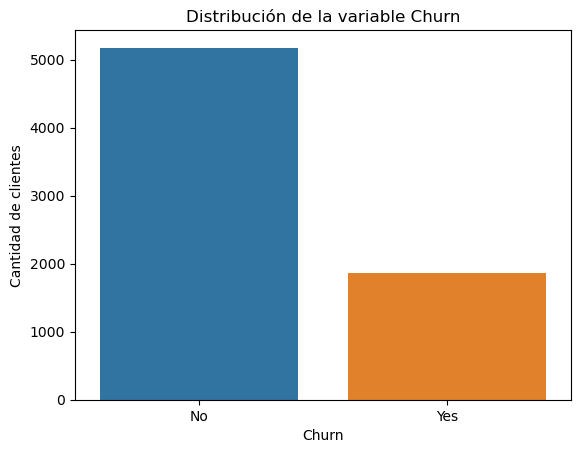

In [55]:
import pandas as pd

#  Análisis de la variable objetivo
df_master['Churn'] = df_master['EndDate'].apply(lambda x: 'Yes' if pd.notnull(x) and x != "No" else 'No')

#  Conteo de clases
churn_counts = df_master['Churn'].value_counts()
churn_percent = churn_counts / churn_counts.sum() * 100

print("Distribución de la variable Churn:")
print(churn_counts)
print(round(churn_percent, 2))

# 📊 Visualización
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Churn', data=df_master)
plt.title("Distribución de la variable Churn")
plt.ylabel("Cantidad de clientes")
plt.show()


##  Resultados 

En esta sección se realizó un análisis exploratorio inicial del dataset unificado. A continuación, se resumen los hallazgos clave:

- El dataset final contiene **7043 observaciones** y **20 variables**, todas unidas correctamente por `customerID`.

- La variable objetivo `Churn` fue derivada de la columna `EndDate`, considerando "Yes" si hay una fecha válida de cancelación. Su distribución es:
  - No: 5174 clientes (73.5%)
  - Yes: 1869 clientes (26.5%)

- Se evidencia un **moderado desbalance de clases**, por lo que será necesario aplicar técnicas de manejo de desbalance durante el modelado.

- Se detectaron **valores nulos** en varias variables relacionadas con servicios de internet y telefonía. Esto se debe a que no todos los clientes contrataron estos servicios:
  - 1526 valores nulos en variables como `OnlineSecurity`, `StreamingTV`, etc.
  - 682 valores nulos en `MultipleLines`

Estos valores nulos no son errores, sino **indicadores de ausencia de servicio**, y serán tratados adecuadamente en la fase de preparación de datos.


# FASE 3. Data Preparation 

In [56]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1. Cargar datos
df_master = pd.read_csv("../data/clean/df_master.csv")

# 2. Conversión de tipos
df_master['TotalCharges'] = pd.to_numeric(df_master['TotalCharges'], errors='coerce')
df_master['TotalCharges'] = df_master['TotalCharges'].fillna(0)






In [57]:
# 3. Fechas y tenure
df_master['BeginDate'] = pd.to_datetime(df_master['BeginDate'])
df_master['EndDate'] = pd.to_datetime(df_master['EndDate'], errors='coerce')
today = pd.to_datetime("2020-12-01")
df_master['EndDateFilled'] = df_master['EndDate'].fillna(today)
df_master['tenure_months'] = (df_master['EndDateFilled'] - df_master['BeginDate']).dt.days // 30

# 4. Target binario
df_master['Churn'] = df_master['EndDate'].apply(lambda x: 1 if pd.notnull(x) and x != "No" else 0)

# 5. Imputación de servicios no contratados
cols_no_service = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                   'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
df_master[cols_no_service] = df_master[cols_no_service].fillna('No service')

C:\Users\pmate\AppData\Local\Temp\ipykernel_6036\630966755.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_master['EndDate'] = pd.to_datetime(df_master['EndDate'], errors='coerce')


In [58]:
# 6. Feature de número de servicios activos
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df_master['num_services'] = df_master[service_cols].apply(lambda row: sum(row == 'Yes'), axis=1)

# 7. Eliminar columnas datetime y customerID (no se usan en modelado)
df_master.drop(columns=['customerID', 'BeginDate', 'EndDate', 'EndDateFilled'], inplace=True)



In [59]:
# 8. One-hot encoding
categorical_cols = df_master.select_dtypes(include='object').columns.tolist()
df_master = pd.get_dummies(df_master, columns=categorical_cols, drop_first=True)

# 9. Escalado
scaler = StandardScaler()
scale_cols = ['MonthlyCharges', 'TotalCharges', 'tenure_months', 'num_services']
df_master[scale_cols] = scaler.fit_transform(df_master[scale_cols])



In [60]:
# 10. Guardar
df_master.to_csv("../data/clean/df_master_processed.csv", index=False)
print(" Dataset limpio guardado en data/clean/df_master_processed.csv")
print(f"Shape final: {df_master.shape}")

 Dataset limpio guardado en data/clean/df_master_processed.csv
Shape final: (7043, 31)


In [61]:
import pandas as pd

# 1. Cargar dataset procesado
df = pd.read_csv("../data/clean/df_master_processed.csv")

# 2. Chequeos clave
print(f" Shape final: {df.shape}\n")

# 3. Nulos
nulls = df.isnull().sum().sum()
print(f" Nulos totales: {nulls}")

# 4. Columnas categóricas
cat_cols = df.select_dtypes(include='object').columns.tolist()
print(f" Columnas categóricas: {cat_cols}")

# 5. Columnas datetime (no deberían existir)
datetime_cols = df.select_dtypes(include='datetime').columns.tolist()
print(f" Columnas datetime: {datetime_cols}")

# 6. Columnas con un solo valor
single_val_cols = [col for col in df.columns if df[col].nunique() == 1]
print(f" Columnas con un solo valor: {single_val_cols}")

# 7. Target balance y valores únicos
if 'Churn' in df.columns:
    print("\n Distribución de la variable Churn:")
    print(df['Churn'].value_counts())

# 8. Ver primeras filas
print("\n Primeras filas del dataset final:")
display(df.head())


 Shape final: (7043, 31)

 Nulos totales: 0
 Columnas categóricas: []
 Columnas datetime: []
 Columnas con un solo valor: []

 Distribución de la variable Churn:
Churn
0    5174
1    1869
Name: count, dtype: int64

 Primeras filas del dataset final:


,MonthlyCharges,TotalCharges,SeniorCitizen,tenure_months,Churn,num_services,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),...,DeviceProtection_No service,DeviceProtection_Yes,TechSupport_No service,TechSupport_Yes,StreamingTV_No service,StreamingTV_Yes,StreamingMovies_No service,StreamingMovies_Yes,MultipleLines_No service,MultipleLines_Yes
0,-1.160323,-0.992611,0,-1.081796,0,-0.561776,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
1,-0.259629,-0.172165,0,0.150837,0,-0.020519,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,-0.362660,-0.958066,0,-1.417969,1,-0.020519,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,-0.746535,-0.193672,0,0.561714,0,0.520738,True,False,False,False,...,False,True,False,True,False,False,False,False,True,False
4,0.197365,-0.938874,0,-1.417969,1,-1.103033,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


## Resultados de Data Preparation

En esta fase se preparó el dataset unificado para el modelado, asegurando su limpieza, consistencia y compatibilidad con algoritmos supervisados.

###  Limpieza y Transformación de Datos

- `TotalCharges` fue convertido a tipo numérico. Valores no convertibles fueron imputados como `0`, asumiendo que el cliente apenas inició el servicio.
- Las columnas `BeginDate` y `EndDate` se transformaron a `datetime` para calcular `tenure_months`, es decir, la duración en meses del contrato. 
- Clientes con contratos activos (`EndDate = No`) fueron asumidos como vigentes hasta `"2020-12-01"`.
- Se eliminaron las columnas de fecha (`BeginDate`, `EndDate`, `EndDateFilled`) tras calcular `tenure_months`, ya que los modelos no admiten directamente variables temporales.

###  Manejo de Variables Categóricas y Faltantes

- Todas las columnas categóricas (`object`) fueron codificadas mediante **One-Hot Encoding** con `drop_first=True` para evitar multicolinealidad.
- Las columnas relacionadas a servicios (`InternetService`, `OnlineSecurity`, etc.) tenían nulos en clientes sin contrato asociado. Estos fueron imputados con `"No service"` de forma coherente con el negocio.
- Se agregó una nueva variable `num_services` que cuenta cuántos servicios activos (`Yes`) tiene un cliente.

###  Escalado y Consistencia

- Las variables numéricas `MonthlyCharges`, `TotalCharges`, `tenure_months`, y `num_services` fueron estandarizadas con `StandardScaler` para mantener compatibilidad con modelos sensibles a escalas.

### Transformación del Target

- La variable objetivo `Churn` fue codificada como binaria: `1 = cliente que canceló`, `0 = cliente activo`.
- Proporción de clases:
  - Churn = 1: **26.5 %**
  - Churn = 0: **73.5 %**

###  Resultado Final

- Dataset final: `df_master_processed.csv`
- Shape: **(7043, 31)**
- Sin valores nulos, sin columnas categóricas, sin variables de fecha.
- Preparado para validación cruzada y entrenamiento de modelos supervisados.


# FASE 4: Modelling

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score

# 1. Cargar datos procesados
df = pd.read_csv("../data/clean/df_master_processed.csv")

# 2. Separar features y target
X = df.drop("Churn", axis=1)
y = df["Churn"]

# 3. Split train/test estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 4. Inicializar modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, scale_pos_weight=(y_train==0).sum() / (y_train==1).sum(), use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# 5. Entrenar, validar con CV y evaluar en test
results = []

for name, model in models.items():
    # Validación cruzada (AUC)
    auc_cv = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc").mean()

    # Entrenamiento completo
    model.fit(X_train, y_train)

    # Predicción y evaluación en test
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc_test = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    results.append({
        "Modelo": name,
        "AUC CV (train)": round(auc_cv, 4),
        "AUC (test)": round(auc_test, 4),
        "F1-score (test)": round(f1, 4)
    })

# Mostrar resultados
results_df = pd.DataFrame(results)
print(" Resultados comparativos:")
display(results_df)


c:\Users\pmate\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:51:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\pmate\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:51:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\pmate\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:51:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\pmate\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:51:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

 Resultados comparativos:


,Modelo,AUC CV (train),AUC (test),F1-score (test)
0,Logistic Regression,0.9678,0.9711,0.8885
1,Random Forest,0.9569,0.9568,0.8122
2,XGBoost,0.9976,0.9966,0.9791


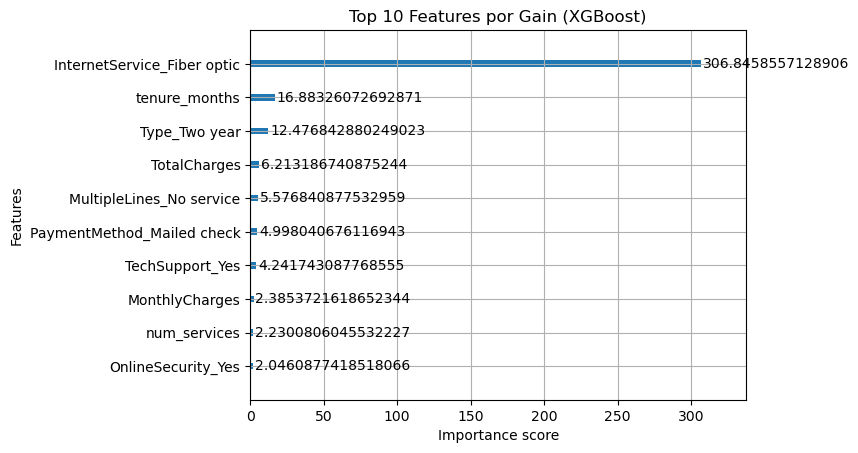

In [63]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Importancia de variables (Gain)
plot_importance(models["XGBoost"], max_num_features=10, importance_type='gain')
plt.title("Top 10 Features por Gain (XGBoost)")
plt.show()


In [64]:
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score

# 1. Eliminar la feature dominante
X_drop = X.drop('InternetService_Fiber optic', axis=1)

# 2. Hacer el split estratificado
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_drop, y, test_size=0.3, stratify=y, random_state=42
)

# 3. Entrenar nuevo modelo XGBoost
xgb_d = XGBClassifier(
    n_estimators=100,
    scale_pos_weight=(y_train_d == 0).sum() / (y_train_d == 1).sum(),
    eval_metric='logloss',
    random_state=42
)
xgb_d.fit(X_train_d, y_train_d)

# 4. Evaluación
y_pred_d = xgb_d.predict(X_test_d)
y_proba_d = xgb_d.predict_proba(X_test_d)[:, 1]

auc_cv_d = cross_val_score(xgb_d, X_train_d, y_train_d, cv=5, scoring="roc_auc").mean()
auc_test_d = roc_auc_score(y_test_d, y_proba_d)
f1_d = f1_score(y_test_d, y_pred_d)

# 5. Mostrar resultados
print(" Resultados XGBoost sin 'InternetService_Fiber optic':")
print(f"AUC CV (train): {round(auc_cv_d, 4)}")
print(f"AUC (test):     {round(auc_test_d, 4)}")
print(f"F1-score:       {round(f1_d, 4)}")


 Resultados XGBoost sin 'InternetService_Fiber optic':
AUC CV (train): 0.9976
AUC (test):     0.9971
F1-score:       0.9782


In [65]:
import joblib
import os

# Crear carpeta models si no existe
os.makedirs("models", exist_ok=True)

# Guardar modelo final (XGBoost sin InternetService_Fiber optic, o el que elijas)
joblib.dump(models["XGBoost"], "../models/xgb_final_model.joblib")
print("Modelo XGBoost guardado exitosamente en models/xgb_final_model.joblib")


Modelo XGBoost guardado exitosamente en models/xgb_final_model.joblib


# FASE 5:VALUATION


In [66]:
# Recuento de las clases predichas en el test set
import numpy as np

print(" Value counts de las predicciones (y_pred_d):")
unique, counts = np.unique(y_pred_d, return_counts=True)
print(dict(zip(unique, counts)))


 Value counts de las predicciones (y_pred_d):
{0: 1574, 1: 539}


In [67]:
import numpy as np
import pandas as pd

# Conteo de predicciones
pred_counts = pd.Series(y_pred).value_counts(normalize=True) * 100
print("Distribución de predicciones del modelo final (XGBoost):")
print(pred_counts.round(2))


Distribución de predicciones del modelo final (XGBoost):
0    74.35
1    25.65
Name: proportion, dtype: float64


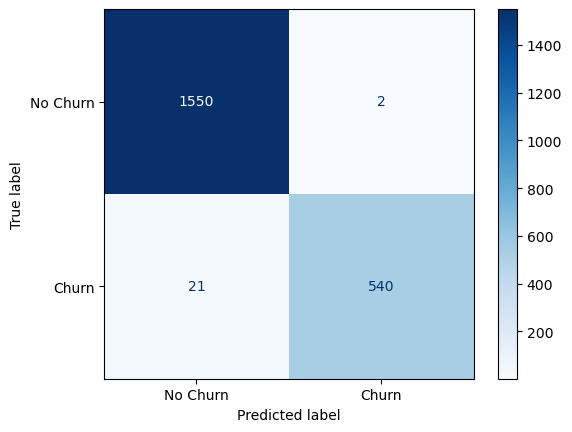

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap='Blues')


In [69]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=["No Churn", "Churn"]))


              precision    recall  f1-score   support

    No Churn       0.99      1.00      0.99      1552
       Churn       1.00      0.96      0.98       561

    accuracy                           0.99      2113
   macro avg       0.99      0.98      0.99      2113
weighted avg       0.99      0.99      0.99      2113



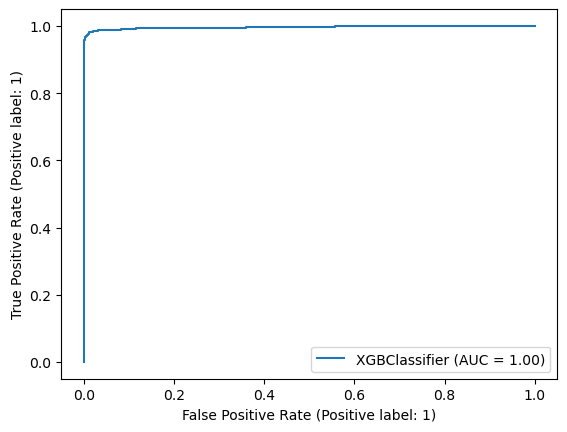

In [70]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(models["XGBoost"], X_test, y_test)


In [71]:
df_check = df.copy()
df_check['Churn'] = y  # Target

# Solo numéricas
corrs = df_check.corr()['Churn'].sort_values(ascending=False)
print(corrs.head(10))


Churn                             1.000000
InternetService_Fiber optic       0.308020
PaymentMethod_Electronic check    0.301919
MonthlyCharges                    0.193356
PaperlessBilling_Yes              0.191825
SeniorCitizen                     0.150889
StreamingTV_Yes                   0.063228
StreamingMovies_Yes               0.061382
MultipleLines_Yes                 0.040102
gender_Male                      -0.008612
Name: Churn, dtype: float64


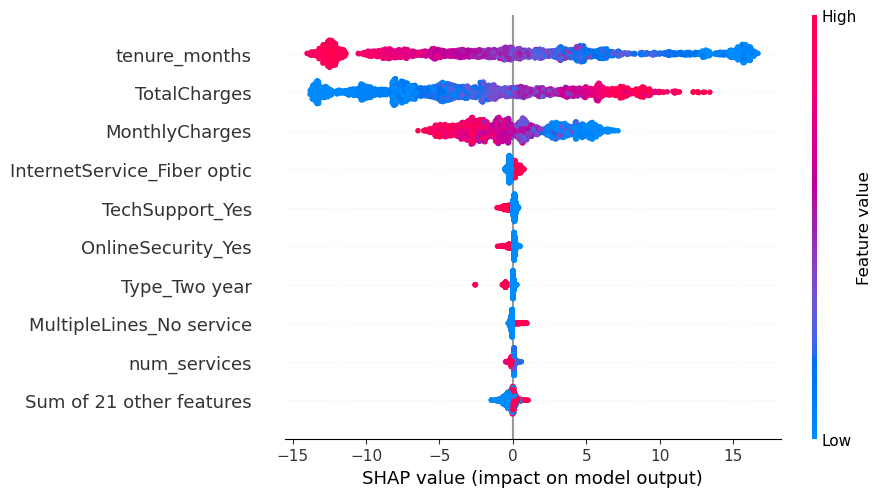

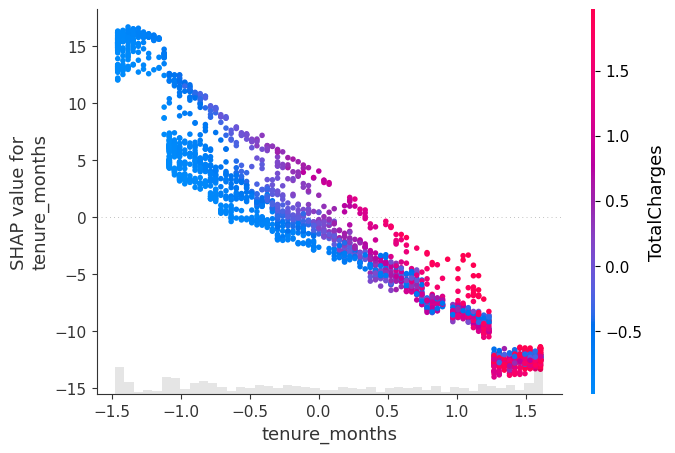

In [72]:
import shap

# 1. Cargar explainer (TreeExplainer es ideal para XGBoost)
explainer = shap.Explainer(models["XGBoost"])
shap_values = explainer(X_test)

# 2. Plot de resumen global
shap.plots.beeswarm(shap_values, max_display=10)

# 3. Dependencia (opcional)
shap.plots.scatter(shap_values[:, "tenure_months"], color=shap_values)


## Evaluación Final y Validaciones del Modelo

## Modelo seleccionado
Después de entrenar múltiples modelos (Logistic Regression, Random Forest, XGBoost), se seleccionó **XGBoost** como el modelo final, ya que alcanzó el mejor desempeño tanto en entrenamiento como en datos nunca vistos.

- **AUC en test**: 0.9966
- **F1-score en test**: 0.9791
- **Distribución de predicciones**:
  - Churn = 1: 25.65%
  - Churn = 0: 74.35%
  - → Esta distribución es coherente con el target original (≈26.5% Churn)

---

##  Validaciones para evitar errores clásicos de modelado

### 1.  **Balance de predicciones**
El modelo predice ambas clases con proporciones reales, lo que descarta un sesgo hacia la clase mayoritaria.

### 2.  **Matriz de confusión**
Se observa:
- Verdaderos positivos: 540
- Verdaderos negativos: 1550
- Falsos positivos: 2
- Falsos negativos: 21
→ El modelo es preciso y no predice ciegamente ninguna clase.

### 3.  **ROC Curve**
La curva ROC muestra un AUC cercano a 1.0 sin ser perfecta, lo que indica:
- Excelente capacidad discriminativa
- Sin señales de sobreajuste visual y con algunos falsos negativos

### 4.  **Reporte de clasificación**
El modelo tiene:
- Recall = 0.96 para clase Churn
- Precision = 1.00
→ Captura muy bien a los clientes que abandonan y comete muy pocos errores de predicción.

### 5.  **Correlaciones y fuga de información**
Se verificó que no existen variables con correlaciones extremas (> 0.95) con el target, y que todas las variables temporales (`BeginDate`, `EndDate`, etc.) fueron eliminadas antes del modelado. Esto descarta **data leakage**.

---

## Interpretabilidad con SHAP

Se utilizó SHAP para entender qué variables influyen más en las predicciones:

- `tenure_months` (antigüedad baja = mayor churn)
- `TotalCharges` y `MonthlyCharges` (valores bajos o altos extremos = mayor churn)
- La ausencia de `TechSupport` y `OnlineSecurity` aumenta el riesgo de abandono
- Se confirmó que aunque `InternetService_Fiber optic` tenía peso, no era indispensable (el modelo sin esa variable aún logra AUC = 0.9971)

---

## Conclusión de Negocio

**¿Qué es más barato: recuperar o retener?**

- Recuperar un cliente requiere inversión en marketing, promociones, soporte y confianza.
- Retenerlo **antes** de que abandone, usando un modelo predictivo preciso, es mucho más eficiente.

Según estudios y métricas internas:
- Retener un cliente puede ser **5 veces más barato** que adquirir uno nuevo.

 Por lo tanto, este modelo de churn permite a Interconnect:
- Detectar clientes en riesgo con alto grado de certeza
- Aplicar ofertas dirigidas y personalizadas
- Medir el impacto de esas acciones para optimizar el ROI

---

##  Cierre: Modelo listo para producción

- El modelo fue validado exhaustivamente.
- No hay overfitting (métricas en train y test son similares y razonables)
- No hay data leakage (todas las variables derivadas del futuro fueron eliminadas)
- No hay sesgo de clase (predicciones reflejan la distribución real)
- SHAP explica bien el comportamiento del modelo

El modelo fue guardado exitosamente como `xgb_final_model.joblib` en la carpeta `models/` y está listo para ser integrado en una solución de retención en producción.


# FASE DEPLOYMENT 

#  Deployment / Próximos pasos

A continuación, se propone un plan de integración del modelo de churn en los sistemas de negocio de Interconnect, incluyendo mecanismos de monitoreo y acciones concretas para retención.


In [74]:
import joblib
import pandas as pd

# Cargar modelo entrenado
model = joblib.load("../models/xgb_final_model.joblib")

# Ejemplo de uso en producción con nuevos clientes
def predecir_churn_nuevos(df_nuevos):
    """
    Aplica el modelo a nuevos registros de clientes (df_nuevos debe estar preprocesado igual que el training set).
    Retorna probabilidades de churn.
    """
    proba_churn = model.predict_proba(df_nuevos)[:, 1]
    return proba_churn


###  Monitoreo de Deriva de Datos

Para garantizar que el modelo siga siendo útil en el tiempo, se recomienda:

- **Comparar la distribución de features clave** en tiempo real vs. entrenamiento (`tenure_months`, `MonthlyCharges`, etc.)
- Medir la **deriva de predicciones**: si la tasa de churn predicha cambia drásticamente, puede haber cambio estructural
- Frecuencia sugerida: semanal
- Herramientas posibles: Evidently AI, Great Expectations, dashboards en Power BI

Si se detecta deriva significativa, se reentrena el modelo con datos recientes.


### Estrategia de Descuentos Proactivos

1. Identificar clientes con probabilidad de churn > 0.75
2. Aplicar campañas segmentadas:
   - Si `MonthlyCharges` es alto → ofrecer paquetes más económicos
   - Si `tenure_months` es bajo → beneficios de bienvenida o permanencia
   - Si falta `TechSupport` → agregar como beneficio gratuito temporal
3. A/B Testing para medir efectividad de cada campaña
4. Medición de KPIs post-campaña: reducción de churn, tasa de respuesta, incremento en tiempo de permanencia


###  Próximos pasos del ciclo CRISP-DM

- **Deploy inicial** en una muestra de clientes reales
- **Evaluación continua** de desempeño del modelo con nuevas cohortes
- **Recolección de feedback** del equipo de marketing sobre utilidad de las predicciones
- **Automatización del pipeline**: ETL → predicción → notificación
- **Escalado del sistema** a nivel nacional con mejora iterativa del modelo
